In [1]:
from pyspark.sql.session import SparkSession
from pyspark import SparkContext
import pyspark
#import pandas
import yaml
import yaycl_crypt
import yaycl
import pandas as pd

In [2]:
sc = SparkContext(master = 'local')
spark = SparkSession(sc)

In [3]:
conf = yaycl.Config('/home/ashishgusai/assesment2/filter-join_DF/', crypt_key='/home/ashishgusai/assesment2/filter-join_DF/secret_text')

In [4]:
yaycl_crypt.decrypt_yaml(conf, 'config')
file1=open("/home/ashishgusai/assesment2/filter-join_DF/config.yaml")
yaycl_crypt.encrypt_yaml(conf, 'config')

cfg=yaml.load(file1)

In [5]:
donationsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/donations.parquet")

In [6]:
donorsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/donors.parquet")

In [7]:
projectsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/projects.parquet")

In [8]:
resourcesDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/resources.parquet")

In [9]:
schoolsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/schools.parquet")

In [10]:
TeachersDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/teachers.parquet")

In [11]:
donor_donation = donationsDF.join(donorsDF,['DonorID'])

In [12]:
project_resource=projectsDF.join(resourcesDF,['ProjectID'],'left_outer')

In [13]:
school_project=projectsDF.join(schoolsDF,['SchoolID'],'right_outer')

In [14]:
project_desc=donationsDF.join(projectsDF,['projectID']).join(donorsDF,['DonorID'])

In [15]:
tempDF=donorsDF.select('DonorState').groupby('DonorState').count().orderBy('count',ascending=False)

In [16]:
tempDF=tempDF.toPandas()

In [17]:
from matplotlib import pyplot as plt
tempDF=tempDF.sort_values(by='count',ascending=False)
tmp=tempDF.head(10)
tmp=tmp.sort_values(by='count')
donor = tmp['count'].tolist()
state = tmp['DonorState'].tolist()
plt.grid(True)
plt.barh(state,donor,label="No. of Donors",color='c')
plt.xlabel("Donors")
plt.ylabel("State")
plt.title("States with Maximum Donors")
plt.legend()


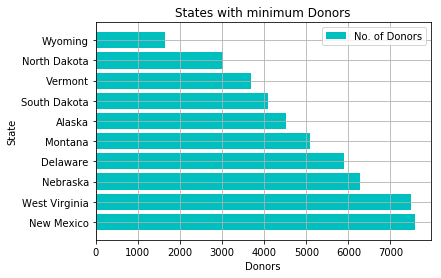

In [18]:
tempDF=tempDF.sort_values(by='count')
tmp=tempDF.head(10)
tmp=tmp.sort_values(by='count',ascending=False)
donor = tmp['count'].tolist()
state = tmp['DonorState'].tolist()
plt.barh(state,donor,label="No. of Donors",color='c')
plt.xlabel("Donors")
plt.ylabel("State")

plt.title("States with minimum Donors")
plt.grid(True)

plt.legend()

In [19]:
tmptech=donorsDF.groupby(['DonorState','DonorIsTeacher']).agg({'DonorIsTeacher':'count'}).orderBy(['DonorState','count(DonorIsTeacher)'],ascending=True).toPandas()

In [20]:
import plotly.graph_objs as go
yes_df=tmptech[tmptech['DonorIsTeacher']=='Yes']
yes_x=yes_df['DonorState']
yes_y = yes_df['count(DonorIsTeacher)']

no_df = tmptech[tmptech['DonorIsTeacher']=='No']
no_x = no_df['DonorState']
no_y = no_df['count(DonorIsTeacher)']


In [21]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
trace1 = go.Bar(
    x=no_x,
    y=no_y,
    name='Non Teacher Donors',
    marker=dict(color='#f259d6'),
    opacity=0.8
)
trace2 = go.Bar(
    x=yes_x,
    y=yes_y,
    name='Teacher Donors',
    marker=dict(color='#f7bb31'),
    opacity=0.8
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    legend=dict(dict(x=-.1, y=1.2)),
    margin=dict(b=120),
    title = 'States and the distribution of Teacher and Non Teacher Donors',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [22]:
no_donation=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'}).orderBy('count(ProjectID)',ascending=False).toPandas()

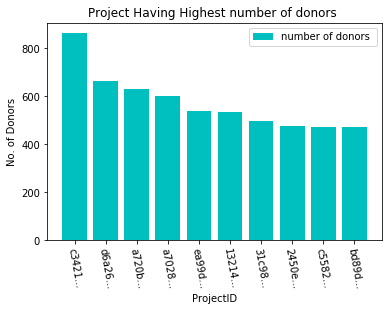

In [23]:
tmp=no_donation.head(10)
project = tmp['ProjectID'].tolist()
project=[project[i][:5]+'...' for i in range(len(project))]
donation = tmp['count(ProjectID)'].tolist()
plt.ylabel("No. of Donors")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)

plt.bar(project,donation,label="number of donors ",color='c')
plt.title("Project Having Highest number of donors ")
plt.legend()


In [24]:
tmpfund=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'}).orderBy('count(ProjectID)',ascending=False).toPandas()

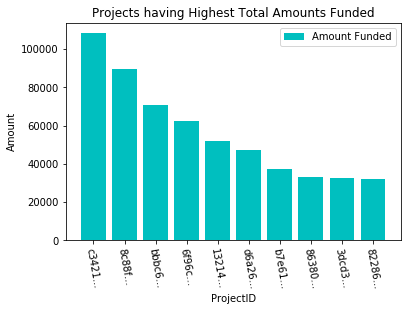

In [25]:
tmp=tmpfund.sort_values(by='sum(DonationAmount)',ascending=False).head(10)
project = tmp['ProjectID'].tolist()
project=[project[i][:5]+'...' for i in range(len(project))]
donation = tmp['sum(DonationAmount)'].tolist()
plt.ylabel("Amount")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)
plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("Projects having Highest Total Amounts Funded")
plt.legend()

In [26]:
tmp_fund=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).toPandas()

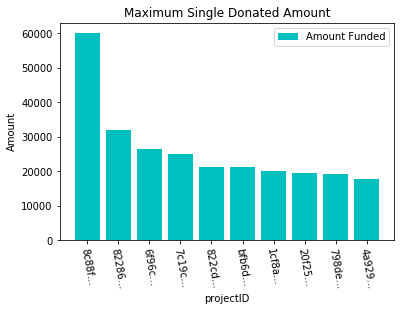

In [27]:

tmp=tmp_fund.sort_values(by='max(DonationAmount)',ascending=False).head(10)
project = tmp['ProjectID'].tolist()
project=[project[i][:5]+'...' for i in range(len(project))]
donation = tmp['max(DonationAmount)'].tolist()
plt.ylabel("Amount")
plt.xlabel("projectID")
plt.xticks(rotation=-80)

plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("Maximum Single Donated Amount")
plt.legend()


In [28]:
tempDF=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'})
tmp_fund=tempDF.withColumn('AvgAm',tempDF['sum(DonationAmount)'] / tempDF['count(ProjectID)']).select('*').filter(tempDF['count(ProjectID)'] > 10).orderBy('AvgAm',ascending=False).toPandas()


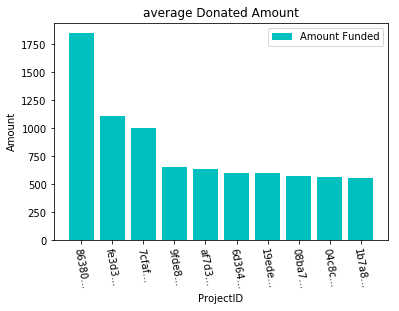

In [29]:
tmp=tmp_fund.sort_values(by='AvgAm',ascending=False).head(10)
project = tmp['ProjectID'].tolist()
project=[project[i][:5]+'...' for i in range(len(project))]
donation = tmp['AvgAm'].tolist()
plt.ylabel("Amount")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)
plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("average Donated Amount")
plt.legend()


In [30]:
#Who are the Top Donors
	#Donors who have made highest number of donations 
tmp_don=donor_donation.groupby('DonorID').agg({'DonorID':'count','DonationAmount':'sum'}).orderBy('count(DonorID)',ascending=False).toPandas()

Text(0.5, 1.0, 'number of donations')

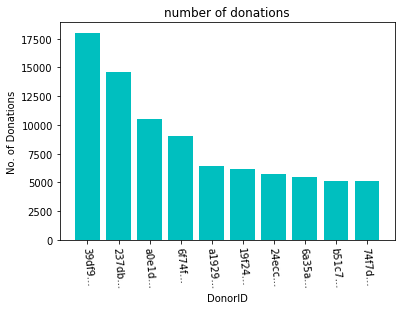

In [31]:
tmp=tmp_don.head(10)
donor = tmp['DonorID'].tolist()
donor=[donor[i][:5]+'...' for i in range(len(donor))]
donor_sum = tmp['count(DonorID)'].tolist()
plt.ylabel("No. of Donations")
plt.xlabel("DonorID")
plt.xticks(rotation=-85)

plt.bar(donor,donor_sum,color='c')
plt.title("number of donations")


In [32]:
tmp_don=donor_donation.groupby('DonorID').agg({'DonorID':'count','DonationAmount':'sum'}).orderBy('sum(DonationAmount)',ascending=False).toPandas()

Text(0.5, 1.0, 'Donors who have funded Highest Total Amounts')

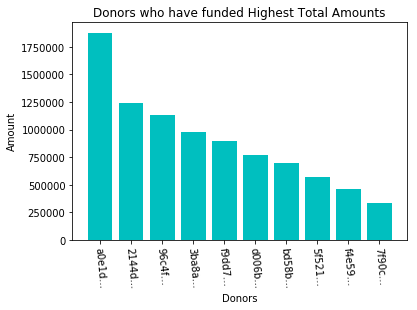

In [33]:
tmp=tmp_don.head(10)
donor = tmp['DonorID'].tolist()
donor=[donor[i][:5]+'...' for i in range(len(donor))]
donor_sum = tmp['sum(DonationAmount)'].tolist()
plt.ylabel("Amount")
plt.xlabel("Donors")
plt.xticks(rotation=-85)

plt.bar(donor,donor_sum,color='c')
plt.title("Donors who have funded Highest Total Amounts")


In [34]:
donationPD=donationsDF.groupby('DonationIncludedOptionalDonation').agg({'DonationIncludedOptionalDonation':'count','DonationAmount':'mean'}).toPandas()

In [35]:
yes_df=donationPD[donationPD['DonationIncludedOptionalDonation']=='Yes']
yes_mean=yes_df['avg(DonationAmount)']
yes_df_1=yes_df['count(DonationIncludedOptionalDonation)']

no_df = donationPD[donationPD['DonationIncludedOptionalDonation']=='No']
no_mean=no_df['avg(DonationAmount)']
no_df_1 =no_df['count(DonationIncludedOptionalDonation)'] 

Text(0.5, 1.0, 'Total Optional Donation')

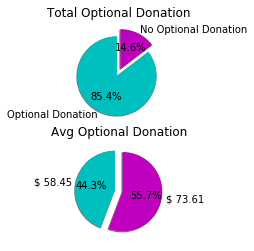

In [36]:
yes_no = [int(yes_df_1),int(no_df_1)]
names = ['Optional Donation','No Optional Donation']
cols = ['c','m']

ynmean=['$ '+str(round(float(yes_mean), 2)),'$ '+str(round(float(no_mean), 2))]
ynmeang=[float(yes_mean),float(no_mean)]
plt.subplot(212)
plt.pie(ynmeang,labels=ynmean,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Avg Optional Donation")

plt.subplot(211)
plt.pie(yes_no,labels=names,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Total Optional Donation")

In [37]:
donor_donationPD=donor_donation.groupby('DonorIsTeacher').agg({'DonorIsTeacher':'count','DonationAmount':'avg'}).toPandas()

In [38]:
teacher_donor=donor_donationPD[donor_donationPD['DonorIsTeacher']=='Yes']
yes_don=teacher_donor['count(DonorIsTeacher)']
yes_avgdon=teacher_donor['avg(DonationAmount)']

non_teacher_donor=donor_donationPD[donor_donationPD['DonorIsTeacher']=='No']
no_don=non_teacher_donor['count(DonorIsTeacher)']
no_avgdon=non_teacher_donor['avg(DonationAmount)']


Text(0.5, 1.0, 'Total teacher and non-teacher donor')

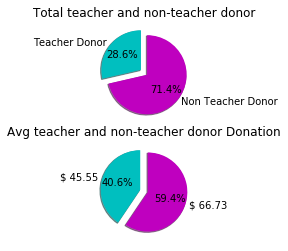

In [39]:
yes_no = [int(yes_don),int(no_don)]
names = ['Teacher Donor','Non Teacher Donor']
cols = ['c','m']

ynmean=['$ '+str(round(float(yes_avgdon),2)),'$ '+str(round(float(no_avgdon),2))]

ynmeang=[float(yes_avgdon), float(no_avgdon)]
plt.subplot(212)
plt.pie(ynmeang,labels=ynmean,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Avg teacher and non-teacher donor Donation")

plt.subplot(211)
plt.pie(yes_no,labels=names,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Total teacher and non-teacher donor")


In [40]:
temp1=donor_donation.groupby('DonorState').agg({'DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).toPandas()

In [41]:
temp2=donor_donation.groupby('DonorCity').agg({'DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).where(donor_donation.DonorCity != 'null' ).toPandas()

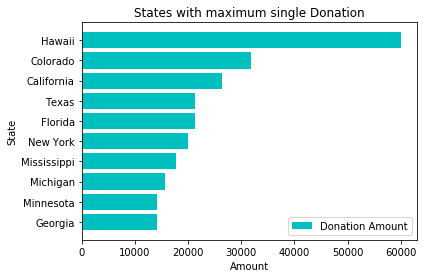

In [42]:
tmp=temp1.head(10)
tmp=tmp.sort_values(by='max(DonationAmount)')
amount = tmp['max(DonationAmount)'].tolist()
state = tmp['DonorState'].tolist()
plt.barh(state,amount,label="Donation Amount",color='c')
plt.xlabel("Amount")
plt.ylabel("State")
plt.title("States with maximum single Donation")
plt.legend()

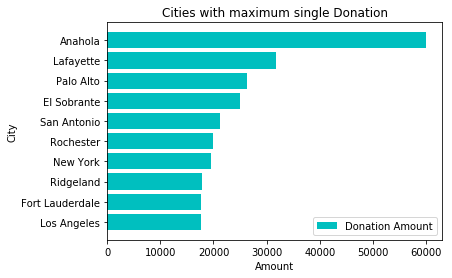

In [43]:
tmp=temp2.head(10)
tmp=tmp.sort_values(by='max(DonationAmount)')
amount = tmp['max(DonationAmount)'].tolist()
state = tmp['DonorCity'].tolist()
plt.barh(state,amount,label="Donation Amount",color='c')
plt.xlabel("Amount")
plt.ylabel("City")
plt.title("Cities with maximum single Donation")
plt.legend()

In [44]:
from matplotlib import style
style.use("ggplot")
from pyspark.sql.functions import year, month, dayofmonth

In [45]:
tmp=TeachersDF.groupby(year(TeachersDF.TeacherFirstProjectPostedDate)).agg({'TeacherID':'count'}).orderBy('year(TeacherFirstProjectPostedDate)').toPandas()


Text(0.5, 0, 'Year')

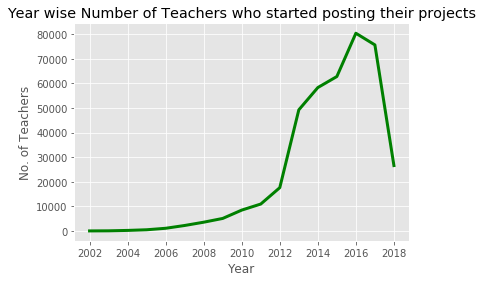

In [46]:
x=tmp['year(TeacherFirstProjectPostedDate)'].tolist()
y=tmp['count(TeacherID)'].tolist()
plt.plot(x,y,'g',linewidth=3)

plt.title("Year wise Number of Teachers who started posting their projects")
plt.ylabel("No. of Teachers")
plt.xlabel("Year")


In [47]:
teachers_df=TeachersDF.toPandas()

In [48]:
t = teachers_df['TeacherPrefix'].value_counts()

labels = t.index
values2 = t.values

trace = go.Pie(labels=labels, values=values2, marker=dict(colors=['#25e475', '#ee1c96',]))

layout = go.Layout(title='Number of Donations with Optional Donations', width=800, height=500)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [49]:
school_df=schoolsDF.toPandas()

Text(0.5, 1.0, 'School Metro Type')

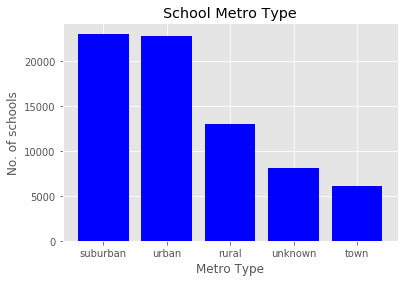

In [50]:

sclmt=school_df['SchoolMetroType'].value_counts()
tmp=sclmt.head(10)
no_scl = sclmt.values
metronm=sclmt.index
plt.ylabel("No. of schools")
plt.xlabel("Metro Type")
plt.bar(metronm,no_scl,color='b')
plt.title("School Metro Type")

Text(0.5, 1.0, 'Top States with maximum Schools')

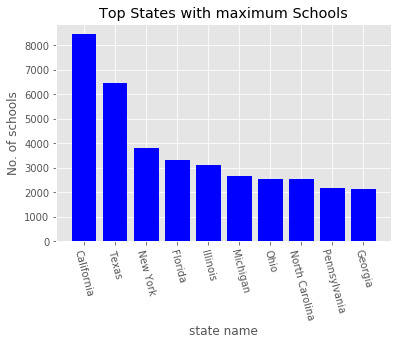

In [51]:
sclsts=school_df['SchoolState'].value_counts()
tmp=sclsts.head(10)
no_scl = tmp.values
state=tmp.index
plt.ylabel("No. of schools")
plt.xlabel("state name")
plt.xticks(rotation=-75)
plt.bar(state,no_scl,color='b')
plt.title("Top States with maximum Schools")


Text(0.5, 1.0, 'Top Cities with maximum Schools')

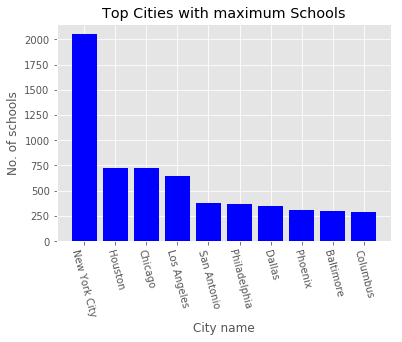

In [52]:
sclct=school_df['SchoolCity'].value_counts()
tmp=sclct.head(10)
no_scl = tmp.values
state=tmp.index
plt.ylabel("No. of schools")
plt.xlabel("City name")
plt.xticks(rotation=-75)
plt.bar(state,no_scl,color='b')
plt.title("Top Cities with maximum Schools")